### 0. Imports and setup

In [1]:
import patsy
import numpy as np
import pandas as pd
import warnings
from datetime import date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf
import pmdarima as pmd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from accurity.functions import (time_series_decompose, time_series_plot, time_series_plot_forecast, time_series_stl_arimax_forecast)

plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
warnings.filterwarnings("ignore")
# %load_ext rpy2.ipython
#plt.style.use('fivethirtyeight')

from IPython import get_ipython
ipython = get_ipython();
ipython.magic("load_ext autoreload");
ipython.magic("autoreload 2");

### 1. Statsmodels OLS model using formula API

In [2]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data
df = df[['Lottery', 'Literacy', 'Wealth', 'Region']].dropna()
df.head()

,Lottery,Literacy,Wealth,Region
0,41,37,73,E
1,38,51,22,N
2,66,13,61,C
3,80,46,76,E
4,79,69,83,E


In [3]:
model = smf.ols(formula='Lottery ~ Literacy + Wealth + Region', data=df)
result = model.fit()
print(result.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.287   
Dependent Variable: Lottery          AIC:                764.5986
Date:               2021-09-03 09:08 BIC:                781.6971
No. Observations:   85               Log-Likelihood:     -375.30 
Df Model:           6                F-statistic:        6.636   
Df Residuals:       78               Prob (F-statistic): 1.07e-05
R-squared:          0.338            Scale:              436.43  
-----------------------------------------------------------------
                 Coef.   Std.Err.    t    P>|t|   [0.025   0.975]
-----------------------------------------------------------------
Intercept        38.6517   9.4563  4.0874 0.0001  19.8255 57.4778
Region[T.E]     -15.4278   9.7273 -1.5860 0.1168 -34.7934  3.9378
Region[T.N]     -10.0170   9.2603 -1.0817 0.2827 -28.4528  8.4188
Region[T.S]      -4.5483   7.2789 -0.6249 0.5339 -19.0394  9.9429
Region[T.W]     -10.0913   

In [4]:
f = 'Lottery ~ Literacy + Wealth + Region + np.log(Wealth)'
y, X = patsy.dmatrices(f, df, return_type='dataframe')

### 2. Airline passengers counts time series analysis (1949-1960)

In [5]:
# Load data
passengers = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', 
                         index_col=0, 
                         header=0, 
                         names=['month', 'observed_raw'])
passengers.index = pd.date_range("1949-01", freq="MS", periods=144)

print(f'Passengers dataset has {len(passengers)} observations.')
passengers.head(5)

Passengers dataset has 144 observations.


,observed_raw
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


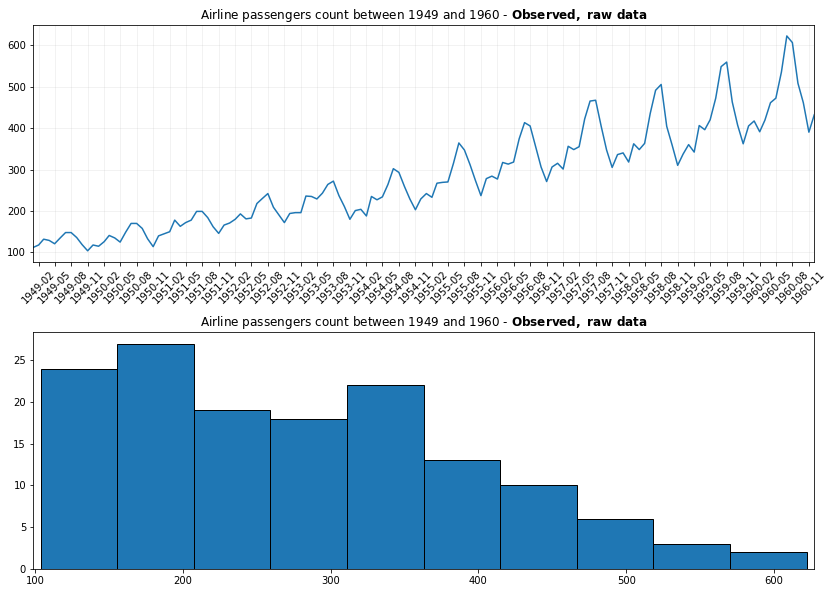

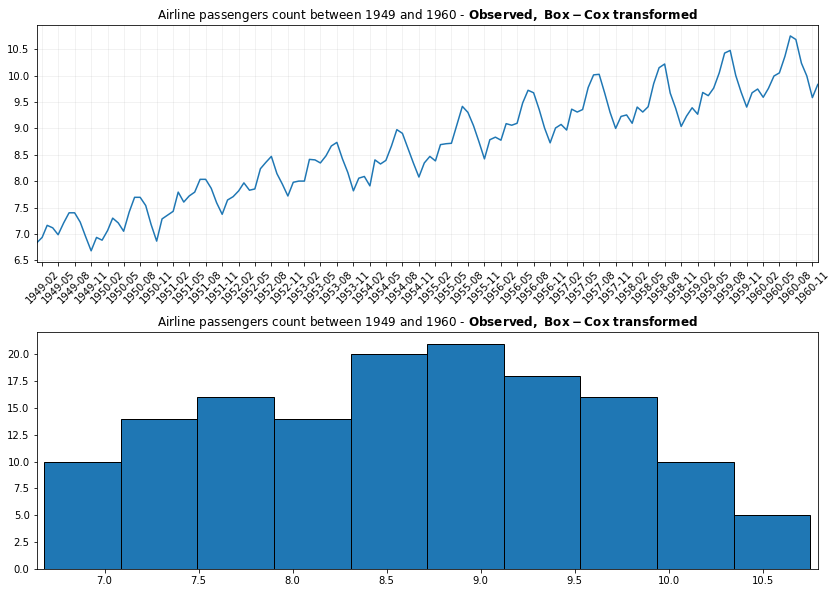

In [19]:
# Plot initial data
time_series_plot(y=passengers.observed_raw, 
                 title='Airline passengers count between 1949 and 1960 -' + ' $\mathbf{Observed, \ raw \ data}$', 
                 xticks_frequency=3,
                 date_format='%Y-%m',
                 date_frequency='month')

# Box-Cox transform
# lmbda = 0.01
passengers['observed_transformed'], lmbda = boxcox(passengers['observed_raw'])
# Plot transformed data
time_series_plot(y=passengers.observed_transformed, 
                 title="Airline passengers count between 1949 and 1960 - $\mathbf{Observed, \ Box-Cox \ transformed}$", 
                 xticks_frequency=3,
                 date_format='%Y-%m',
                 date_frequency='month')

,observed,trend,seasonal,residual,seasonally adjusted
1949-01-01,6.827490,NaN,-0.186270,NaN,7.013760
1949-02-01,6.932822,NaN,-0.256819,NaN,7.189641
1949-03-01,7.161892,NaN,0.041505,NaN,7.120386
1949-04-01,7.114611,NaN,-0.025950,NaN,7.140560
1949-05-01,6.983787,NaN,-0.013922,NaN,6.997709
...,...,...,...,...,...
1960-08-01,10.684049,NaN,0.480129,NaN,10.203920
1960-09-01,10.234573,NaN,0.153200,NaN,10.081373
1960-10-01,9.992159,NaN,-0.162689,NaN,10.154848
1960-11-01,9.582623,NaN,-0.474275,NaN,10.056898


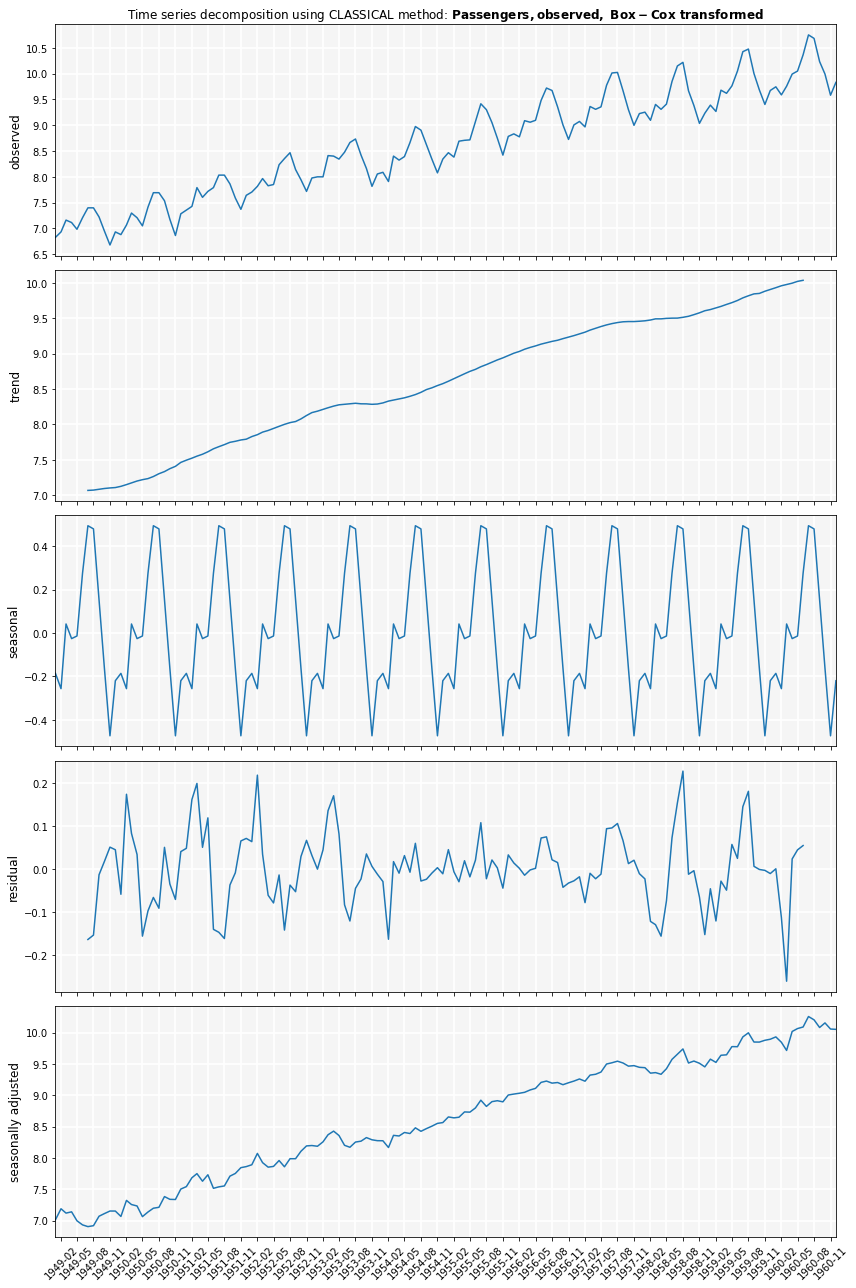

In [24]:
# Decomposition of Box-Cox transformed time series using classical or STL method
time_series_decompose(y=passengers.observed_transformed, 
                    method='classical', 
                    period=12, 
                    stl_seasonal=33,
                    stl_trend_deg=1,
                    stl_seasonal_deg=1,
                    stl_low_pass_deg=1,
                    xticks_frequency=3, 
                    title='$\mathbf{Passengers, observed, \ Box-Cox \ transformed}$', 
                    date_format='%Y-%m',
                    date_frequency='month',
                    return_type='both')

AICc = -378.8223 
 AIC = -379.1121 
 MSE =0.3447
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 193.556
Date:                Fri, 03 Sep 2021   AIC                           -379.112
Time:                        13:40:01   BIC                           -367.261
Sample:                    01-01-1949   HQIC                          -374.296
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6051      0.064      9.407      0.000       0.479       0.731
ar.L2          0.3940      0.063      6.250      0.000       0.270       0.518
ma.

,observed_raw,observed_transformed,observed_transformed_seasonal_adjusted,predicted_transformed,regression_residual,arima_residual,pi_lower_transformed,pi_upper_transformed,predicted_raw,pi_lower_raw,pi_upper_raw
1960-11-01,390.0,9.582623,10.112366,9.623900,-0.041278,-0.666355,9.502489,9.745311,396.705063,377.258626,416.999087
1960-12-01,432.0,9.831860,10.141076,9.848414,-0.016553,-0.267226,9.727003,9.969824,434.920827,413.883402,456.862516
1961-01-01,NaN,NaN,NaN,9.939953,NaN,NaN,9.818543,10.061363,451.378541,429.662378,474.022912
1961-02-01,NaN,NaN,NaN,9.748973,NaN,NaN,9.606133,9.891812,417.624548,393.807019,442.658513
1961-03-01,NaN,NaN,NaN,10.081953,NaN,NaN,9.910318,10.253588,477.957576,445.993338,511.853232
1961-04-01,NaN,NaN,NaN,10.127491,NaN,NaN,9.934145,10.320837,486.758629,450.318748,525.681244
1961-05-01,NaN,NaN,NaN,10.241234,NaN,NaN,10.026622,10.455846,509.346930,467.446613,554.405553
1961-06-01,NaN,NaN,NaN,10.620986,NaN,NaN,10.387004,10.854969,591.349307,539.596129,647.272771
1961-07-01,NaN,NaN,NaN,10.972265,NaN,NaN,10.719774,11.224756,676.961814,614.435907,744.828939
1961-08-01,NaN,NaN,NaN,10.960204,NaN,NaN,10.690105,11.230304,673.856628,607.422992,746.382960


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
residual_acf,-0.042761,-0.114290,-0.083317,-0.119222,0.124156,0.114224,-0.080115,0.042446,0.164027,-0.106800,-0.045349,-0.131209,-0.050162,0.115097,0.084557,-0.159932,0.067591,0.080964,-0.081799,0.019288
q_stat,0.267945,2.198034,3.210887,5.331686,7.647756,9.628273,10.606017,10.881837,15.052262,16.828942,17.156705,19.903801,20.296129,22.423167,23.584391,27.789849,28.558935,29.674551,30.787693,30.852000
p_value,0.604713,0.333198,0.360239,0.254925,0.176747,0.141205,0.156751,0.208485,0.089510,0.078236,0.103325,0.068928,0.088068,0.070327,0.072496,0.033496,0.038816,0.040733,0.042591,0.057175


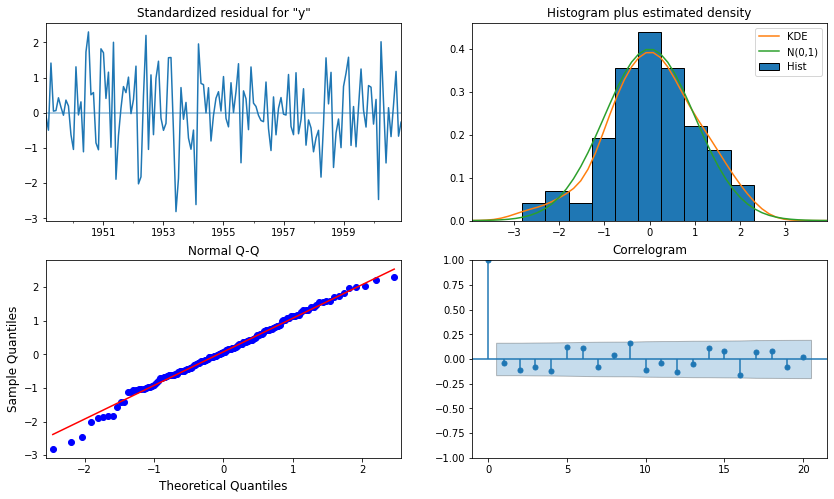

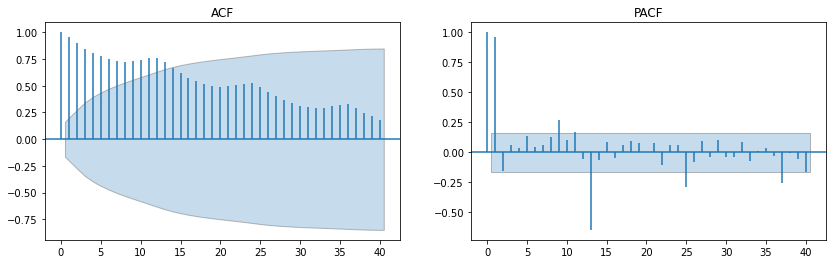

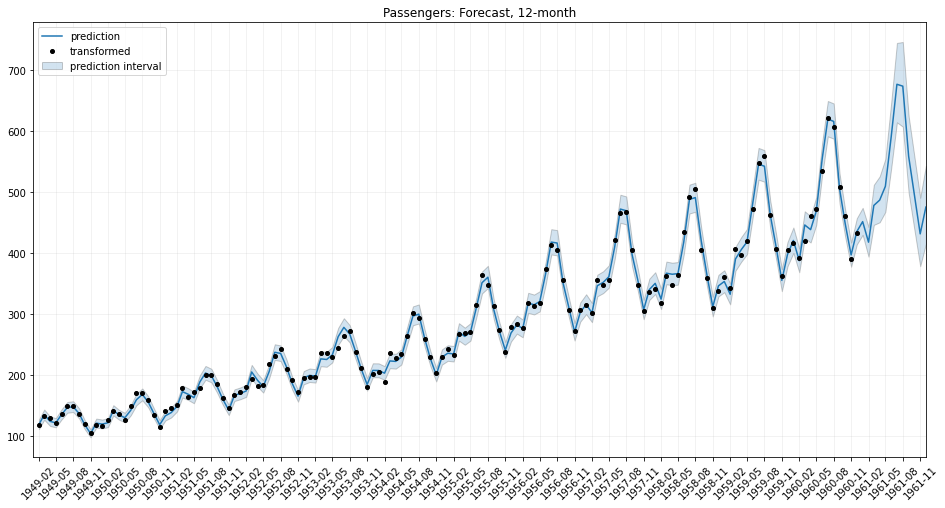

In [26]:
# from Codebase.Functions.functions import (time_series_decompose, time_series_plot, time_series_plot_forecast, time_series_stl_arimax_forecast)
# 12-month forecast of Box-Cox transformed time series using STL-ARIMAX forecasting method (STL decomposition + ARIMAX)
passengers_forecast, residual_acf, stl_forecast_model = time_series_stl_arimax_forecast(data=passengers,
                                                                                        y=passengers.observed_transformed,
                                                                                        period=12,
                                                                                        model=ARIMA,
                                                                                        stl_seasonal=33,
                                                                                        arima_order=(2, 1, 1),
                                                                                        arima_trend='n',
                                                                                        forecast_steps=12,
                                                                                        alpha=0.05,
                                                                                        auto_ylims=False,
                                                                                        bartlett_confint=True,
                                                                                        lmbda=lmbda,
                                                                                        nlags=20,
                                                                                        df_adjust=True,
                                                                                        plot_type='raw',
                                                                                        plot_start_idx=1,
                                                                                        plot_title='Passengers: Forecast, 12-month')
display(passengers_forecast[142:])
display(residual_acf)
pd.Series(stl_forecast_model.model_result.filter_results.standardized_forecasts_error[0], name='resid').to_csv('C:\Miro\Python\\resid.csv')

In [ ]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('MSFT Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['Open'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()

In [53]:
aus_visit = pd.read_csv('C:\\Miro\\Python\\Data Science\\Models\\Time Series\\aus_visit.txt')
aus_visit.index = pd.period_range("1999-Q1", freq="Q", periods=68)
aus_visit.drop(columns='period', inplace=True)
aus_visit

,value
1999Q1,30.05251
1999Q2,19.14850
1999Q3,25.31769
1999Q4,27.59144
2000Q1,32.07646
...,...
2014Q4,59.83447
2015Q1,73.25703
2015Q2,47.69662
2015Q3,61.09777


In [58]:
y = passengers_forecast.observed_transformed_seasonal_adjusted[:144]


	Ljung-Box test

data:  Residuals from ARIMA(2,1,1)
Q* = 16.9, df = 7, p-value = 0.01805

Model df: 3.   Total lags used: 10

Series: y 
ARIMA(2,1,1) 

Coefficients:
         ar1     ar2      ma1
      0.6079  0.3920  -0.9933
s.e.  0.0768  0.0768   0.0106

sigma^2 estimated as 0.003901:  log likelihood=193.76
AIC=-379.52   AICc=-379.23   BIC=-367.67


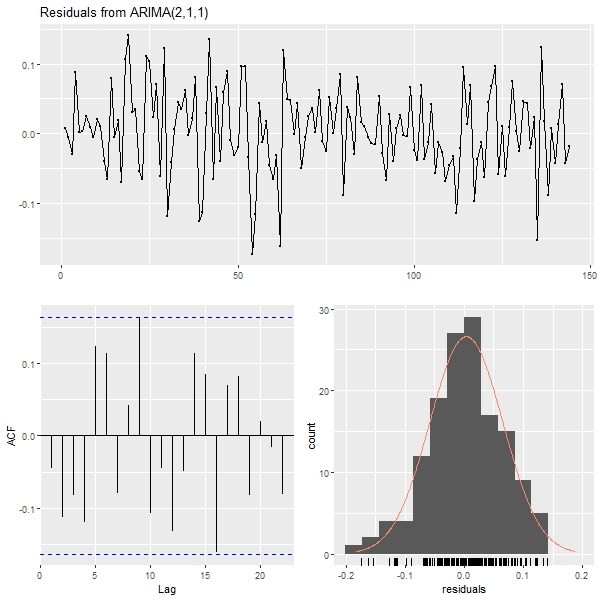

In [59]:
%%R -i y -w 600 -h 600
library(fpp2)
library(forecast)
fit <- Arima(y, order=c(2,1,1), include.constant=FALSE)

# cbind("Regression Errors" = residuals(fit, type="regression"), "ARIMA errors" = residuals(fit, type="innovation")) %>% autoplot(facets=TRUE)
checkresiduals(fit)
fit

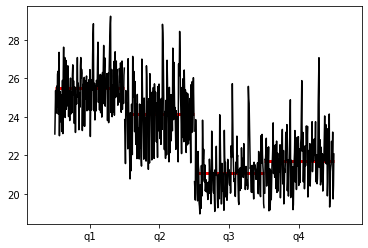

In [37]:
dta = sm.datasets.elnino.load_pandas().data
dta['YEAR'] = dta.YEAR.astype(int).astype(str)
dta = dta.set_index('YEAR').T.unstack()
dates = pd.to_datetime(list(map(lambda x: '-'.join(x) + '-1',
                                dta.index.values)))
dta.index = dates.to_period('Q')
fig = sm.graphics.tsa.quarter_plot(dta)

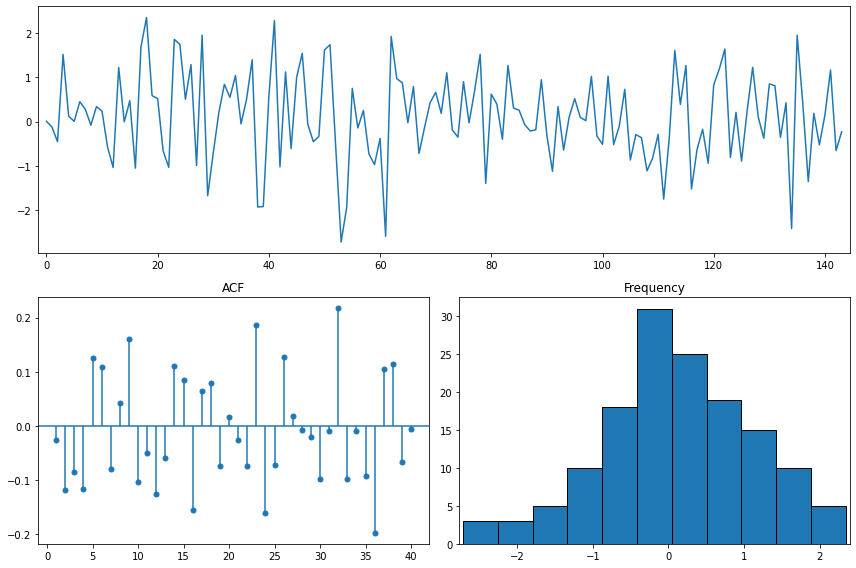

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 195.866
Date:                Fri, 08 Jan 2021   AIC                           -379.731
Time:                        00:38:12   BIC                           -361.954
Sample:                             0   HQIC                          -372.508
                                - 144                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0722      0.022      3.340      0.001       0.030       0.115
drift         -0.0001      0.000     -0.502      0.615      -0.001       0.000
ar.L1         -1.3809      0.342     -4.043      0.000      -2.050      -0.711
ar.L2         -0.4726      0.147     -3.211      0.001      -0.761      -0.184
ma.L1          0.8640      0.373      2.316      0.021       0.133       1.595
sigma2         0.0037      0.000      7.569      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 1.81
Prob(Q):                              0.43   Prob(JB):                         0.40
Heteroskedasticity (H):               0.73   Skew:                            -0.27
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

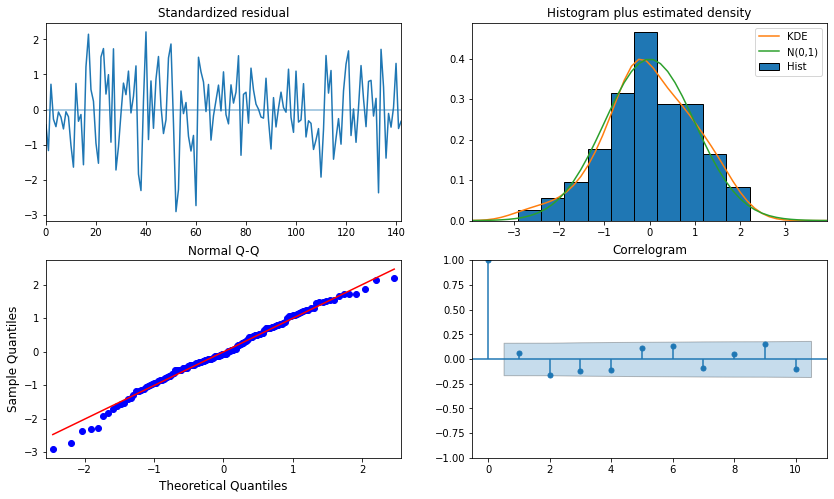

In [41]:
import pmdarima as pm
pmd.utils.tsdisplay(stl_forecast_model.model_result.filter_results.standardized_forecasts_error[0], lag_max=40, figsize=(12,8), bins=11, acf_kwargs={'zero': False})
y = pm.datasets.load_lynx()

# ARMA model
arma = pm.ARIMA(order=(2,1,1), trend='ct').fit(passengers_forecast.observed_transformed_seasonal_adjusted[:144])
arma.plot_diagnostics(figsize=(14,8)).show()
arma.summary()

In [43]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as tsa
import warnings
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages

from scipy.stats import boxcox
from statsmodels.datasets import passengers, nile
from statsmodels.tsa.arima.model import ARIMA
from numpy.testing import (assert_, assert_almost_equal, assert_equal, assert_allclose, assert_raises)
from rpy2.robjects import r
from rpy2.robjects.packages import importr, isinstalled
from rpy2.robjects.vectors import StrVector, IntVector, FloatVector
warnings.filterwarnings("ignore")

#passengers = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', index_col=0, header=0, names=['month', 'observed_raw'])
data = pd.DataFrame(passengers.data.load_pandas().data.Passengers)
data['observed_transformed'], lmbda = boxcox(data['Passengers'])

model = tsa.STLForecast(endog=data['observed_transformed'], 
                        model=ARIMA, 
                        seasonal=33,
                        model_kwargs={'order': (2,1,1), 'trend': 'n', 'freq': data.index.freq},
                        period=12).fit()

residual_acf = pd.DataFrame({'residual_acf': tsa.acf(model.model_result.filter_results.standardized_forecasts_error[0], 
                                                     adjusted=False, nlags=10, qstat=True, fft=False, alpha=0.05)[0][1:], 
                             'q_statistic': model.model_result.test_serial_correlation(method='ljungbox', lags=10, df_adjust=True)[0][0],
                             'p_value': model.model_result.test_serial_correlation(method='ljungbox', lags=10, df_adjust=True)[0][1]}, index=np.arange(1, 11)).T

pasengers_seasonally_adjusted = model.result.resid + model.result.trend  

df_model = model.model_result.df_model
model.model_result.df_model

# utils = importr('utils')
# utils.chooseCRANmirror(ind=1) 
# packnames = ('forecast', 'fpp2')
# names_to_install = [x for x in packnames if not isinstalled(x)]
# if len(names_to_install) > 0:
#     utils.install_packages(StrVector(names_to_install))

# forecast = importr('forecast')
# stats = importr('stats')
# base = importr('base')

# passengers_data = FloatVector(pasengers_seasonally_adjusted)
# fit = forecast.Arima(y=passengers_data, order=IntVector([2,1,1]), include_constant=False)
# res = forecast.checkresiduals(fit, plot=False)[2][0]
#res

4

In [47]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
niledata = nile.data.load_pandas().data
niledata.index = pd.date_range('1871-01-01', '1970-01-01', freq='AS')
mod = SARIMAX(endog=niledata['volume'], order=(1,0,1), trend='n', freq=niledata.index.freq)
res = mod.fit()

actual = res.test_serial_correlation(method='ljungbox', lags=10, df_adjust=True)[0, :, -1]
assert_allclose(actual, [14.116, 0.0788], atol=1e-3)

array([14.11586151,  0.07879507])